In [ ]:
import pandas as pd
import re

# Try to import matplotlib, install if not available
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    import subprocess
    
    print("matplotlib not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    

def plot_temporal_themes(csv_path, themes, date_col="date", text_col="review_text", 
                         date_format="%d/%m/%Y", title="Quarterly Theme Trends", 
                         figsize=(12, 6)):
    
    
    # =========================
    # 1. LOAD DATA
    # =========================
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.lower()
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors="coerce")
    df = df.dropna(subset=[date_col])
    
    # =========================
    # 2. THEME MATCHING
    # =========================
    def assign_themes(text):
        text = str(text).lower()
        matched = []
        for theme, keywords in themes.items():
            for kw in keywords:
                if re.search(r"\b" + re.escape(kw) + r"\b", text):
                    matched.append(theme)
                    break
        return matched
    
    df["themes"] = df[text_col].apply(assign_themes)
    df_exploded = df.explode("themes").dropna(subset=["themes"])
    
    # =========================
    # 3. MONTHLY DATA 
    # =========================
    df_exploded["month"] = df_exploded[date_col].dt.to_period("M").dt.to_timestamp()
    monthly_counts = df_exploded.groupby(["month", "themes"]).size().reset_index(name="count")
    monthly_pivot = monthly_counts.pivot(index="month", columns="themes", values="count").fillna(0)
    
    # Find peak theme and month
    max_theme = monthly_pivot.sum().idxmax()
    max_month_value = monthly_pivot[max_theme].max()
    max_month_date = monthly_pivot[max_theme].idxmax()
    
    # =========================
    # 4. QUARTERLY DATA (FOR PLOTTING)
    # =========================
    df_exploded["quarter"] = df_exploded[date_col].dt.to_period("Q").dt.to_timestamp()
    quarterly_counts = df_exploded.groupby(["quarter", "themes"]).size().reset_index(name="count")
    pivot_df = quarterly_counts.pivot(index="quarter", columns="themes", values="count").fillna(0)
    
    # Create quarter labels like "Q1-2023"
    quarter_labels = [f"Q{q}-{d.year}" for d, q in zip(pivot_df.index, pivot_df.index.quarter)]
    
    # =========================
    # 5. PLOT WITH LIGHT THEME 
    # =========================
    plt.figure(figsize=figsize)
    plt.gcf().set_facecolor('white')  
    plt.gca().set_facecolor('white')  
    
    # Plot each theme as a line with markers
    for theme in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[theme], linestyle='-', linewidth=2, label=theme)
    
    # add marker = 'o' for dots on lines

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Quarter')
    plt.ylabel('Number of Reviews')
    
    # Format x-axis ticks
    num_quarters = len(pivot_df.index)
    if num_quarters > 8:
        step = max(1, num_quarters // 6)
        plt.xticks(pivot_df.index[::step], quarter_labels[::step], rotation=45)
    else:
        plt.xticks(pivot_df.index, quarter_labels, rotation=45)
    
    # =========================
    # 6. PEAK ANNOTATION (SIMILAR TO create_line_graph)
    # =========================
    # Find the quarter containing the peak month
    peak_quarter = max_month_date.to_period("Q").to_timestamp()
    
    if peak_quarter in pivot_df.index:
        peak_q_value = pivot_df.loc[peak_quarter, max_theme]
        
        # Add peak annotation similar to create_line_graph
        plt.annotate(f'Peak: {max_month_date.strftime("%b %Y")}\n{int(max_month_value)} reviews',
                    xy=(peak_quarter, peak_q_value),
                    xytext=(peak_quarter, peak_q_value * 1.15),
                    ha='center', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=10)
        
        # Add subtle vertical line at peak
        plt.axvline(x=peak_quarter, linestyle='--', color='red', alpha=0.3)
    
    # Add grid and legend
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # =========================
    # 7. SUMMARY OUTPUT
    # =========================
    print("=" * 60)
    print("PEAK ANALYSIS SUMMARY")
    print("=" * 60)
    print(f"Peak Theme: {max_theme}")
    print(f"Peak Month: {max_month_date.strftime('%B %Y')}")
    print(f"Monthly Peak Value: {int(max_month_value)} reviews")
    print(f"Quarter Containing Peak: Q{peak_quarter.quarter}-{peak_quarter.year}")
    print("=" * 60)
    
    # return pivot_df  # Commented out for table

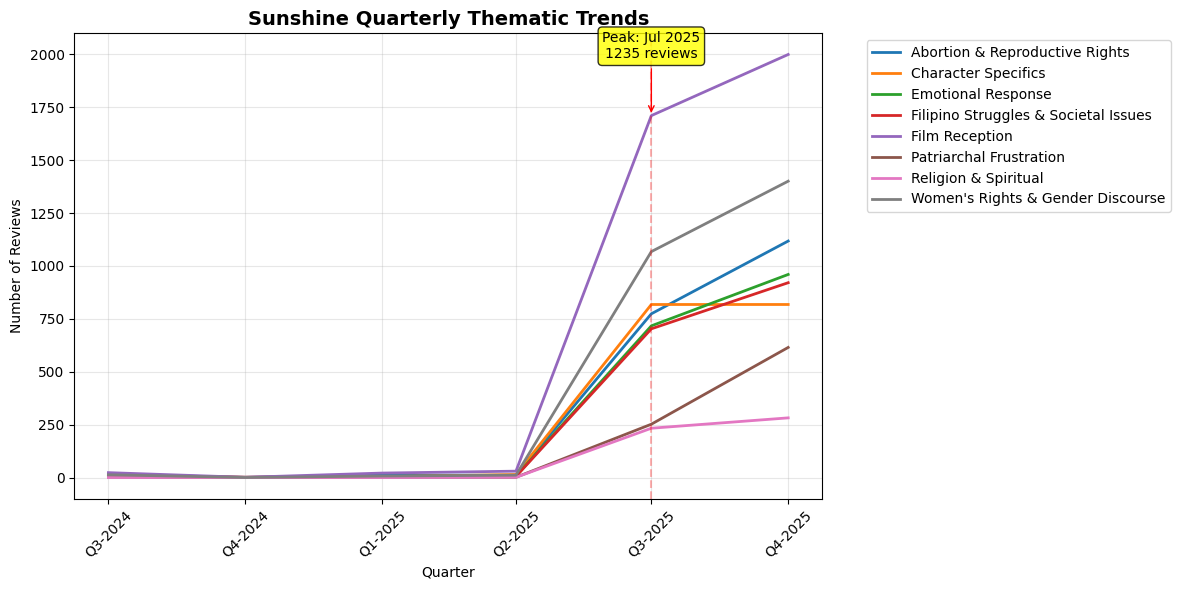

PEAK ANALYSIS SUMMARY
Peak Theme: Film Reception
Peak Month: July 2025
Monthly Peak Value: 1235 reviews
Quarter Containing Peak: Q3-2025


In [23]:
sunshine_themes = {
    "Abortion & Reproductive Rights": [
        "abortion", "legalize", "healthcare", "pregnancy",
        "teenage pregnancy", "aborsyon", "hope"
    ],
    "Women's Rights & Gender Discourse": [
        "women", "woman", "body", "kababaihan", "society",
        "pangarap", "aspirations", "motherhood", "ayoko maging"
    ],
    "Film Reception": [
        "watch", "good", "film", "ending", "ganda", "galing",
        "love", "thank", "masterpiece", "cinema", "best", "lakas", "real"
    ],
    "Patriarchal Frustration": [
        "fuck men", "men", "hate", "lalaki", "lalake"
        "tangina lalaki", "putangina", "tito bobot"
    ],
    "Filipino Struggles & Societal Issues": [
        "hirap", "hirap maging", "pilipinas", "pangarap",
        "maging pilipinas", "country", "iyak", "held", "breaking",
        "puta"
    ],
    "Emotional Response": [
        "mahal", "ily", "love", "ramdam", "undestand",
        "cried", "tears", "love love", "hug", "shine", "loved",
        "realistic", "reality"
    ],
    "Character Specifics": [
        "maris racal", "miggy", "elijah", "actress",
        "performance", "peak", "galing", "canlas", "naiintindihan"
    ],
    "Religion & Spiritual": [
        "god", "pastor", "papa god", "thank"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/sunshine_reviews.csv",
                     themes=sunshine_themes,
                     title="Sunshine Quarterly Thematic Trends")

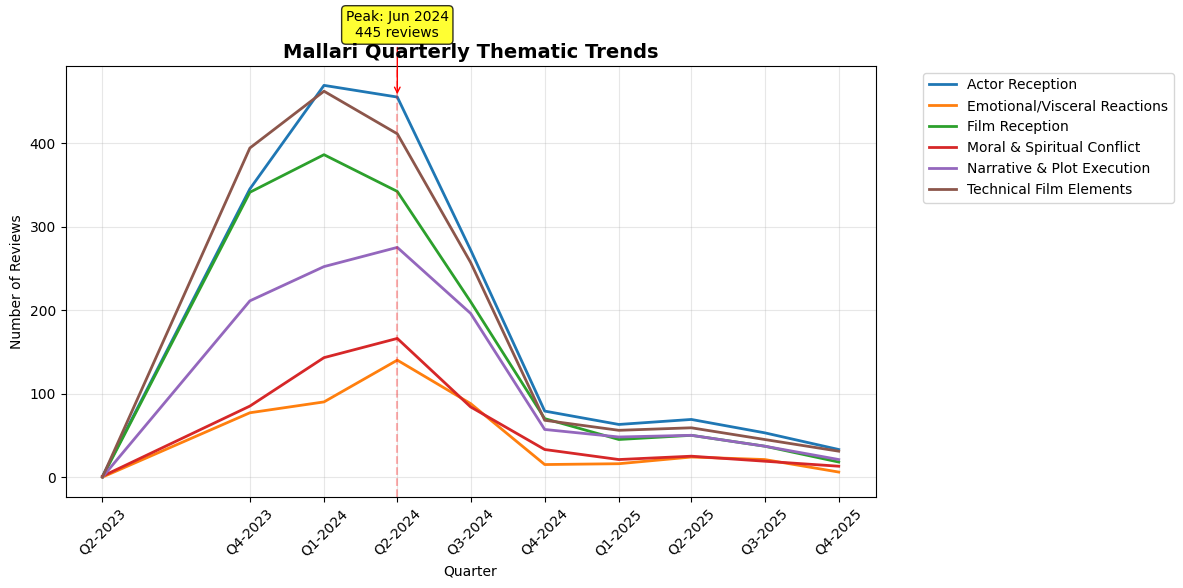

PEAK ANALYSIS SUMMARY
Peak Theme: Actor Reception
Peak Month: June 2024
Monthly Peak Value: 445 reviews
Quarter Containing Peak: Q2-2024


In [24]:
mallari_themes = {
    "Actor Reception": [
        "piolo", "pascual", "pogi", "acting", "hot", "biceps", "stars", "papa", "pogi papa", "janella", "salvador"
    ],
    "Technical Film Elements": [
        "horror", "film", "movies", "good", "scary", "jumpscares", "cinematography", "cinematic", "plot"
    ],
    "Narrative & Plot Execution": [
        "ideas", "wasted", "ending", "time travel", "multiverse", "story", "concept", "disappointing", "poorly"
    ],
    "Emotional/Visceral Reactions": [
        "fuck", "shit", "tangina", "dumb", "cried", "scary", "curse"
    ],
    "Moral & Spiritual Conflict": [
        "father severino", "papa", "curse", "generational trauma"
    ],
    "Film Reception": [
        "Plot", "good", "film", "movies", "best", "entertaining", "watch", "like"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/mallari_reviews.csv",
                     themes=mallari_themes,
                     title="Mallari Quarterly Thematic Trends")

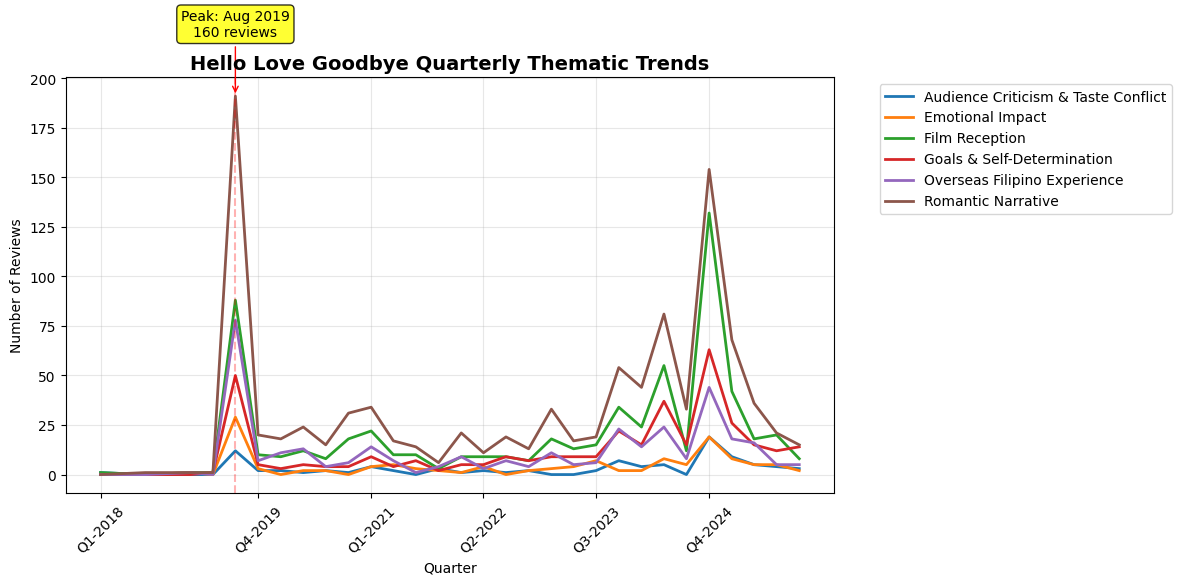

PEAK ANALYSIS SUMMARY
Peak Theme: Romantic Narrative
Peak Month: August 2019
Monthly Peak Value: 160 reviews
Quarter Containing Peak: Q3-2019


In [25]:
hellolovegoodbye_themes = {
    "Romantic Narrative": [
        "love", "story", "romance", "relationships", "film"
    ],
    "Goals & Self-Determination": [
        "dreams", "choose", "career", "pangarap", "sarili", "canada"
    ],
    "Overseas Filipino Experience": [
        "hong kong", "hk", "overseas", "land", "version", "pinoy", "philippines"
    ],
    "Film Reception": [
        "watched", "rewatch", "rewatched", "rewatching", "maganda", "ganda", "good"
    ],
    "Emotional Impact": [
        "cried", "tears", "sad", "depressing", "kms"
    ],
    "Audience Criticism & Taste Conflict": [
        "corny", "baduy", "version", "maine", "anong"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/hellolovegoodbye_reviews.csv",
                     themes=hellolovegoodbye_themes,
                     title="Hello Love Goodbye Quarterly Thematic Trends")

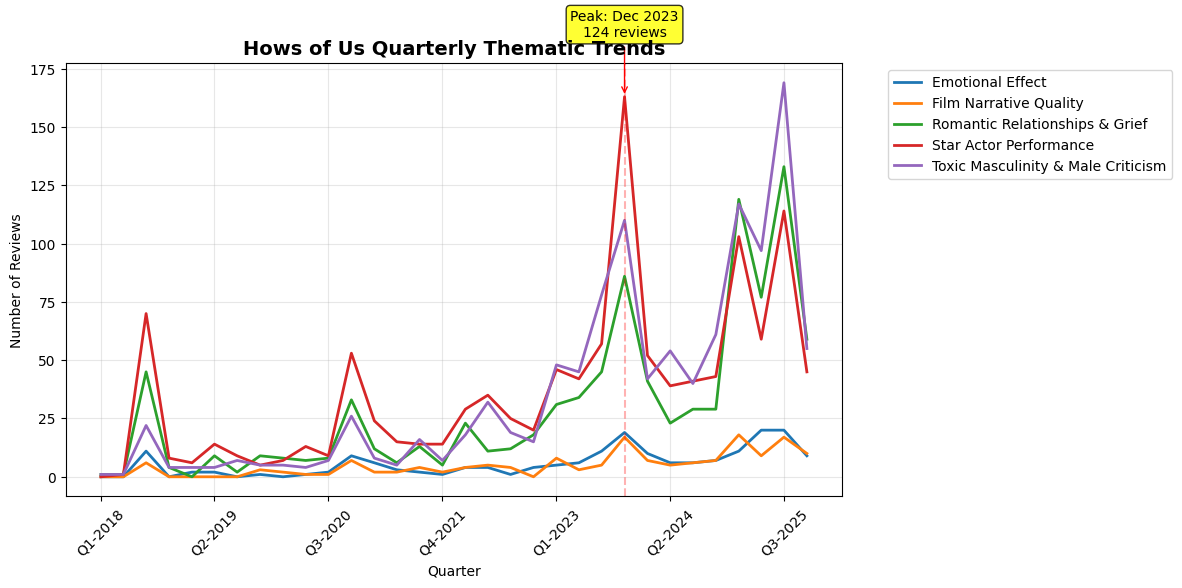

PEAK ANALYSIS SUMMARY
Peak Theme: Star Actor Performance
Peak Month: December 2023
Monthly Peak Value: 124 reviews
Quarter Containing Peak: Q4-2023


In [26]:
howsofus_themes = {
    "Romantic Relationships & Grief": [
        "love", "relationship", "heart", "stay", "reason", "rewatch", "watch", "great film", "love love", "binalikan", "nagkabalikan", "sakit", "hurt", "left", "ramdam"
    ],
    "Toxic Masculinity & Male Criticism": [
        "fuck men", "tangina primo", "red flag", "tangina", "hate", "boy", "primo"
    ],
    "Star Actor Performance": [
        "kathryn", "kathniel", "daniel", "acting", "carried", "stars", "performance"
    ],
    "Film Narrative Quality": [
        "plot ", "corny", "panget", "music", "unnecessary jokes", "opm"
    ],
    "Emotional Effect": [
        "cried", "sobbed", "crying", "eyes", "sakit", "hurts"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/howsofus_reviews.csv",
                     themes=howsofus_themes,
                     title="Hows of Us Quarterly Thematic Trends")

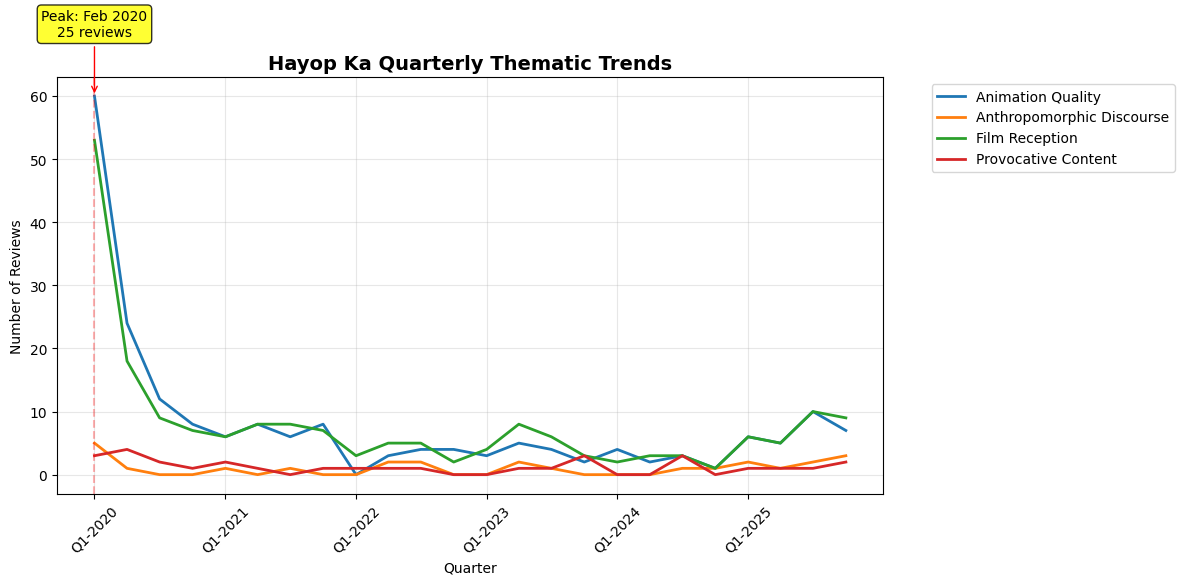

PEAK ANALYSIS SUMMARY
Peak Theme: Animation Quality
Peak Month: February 2020
Monthly Peak Value: 25 reviews
Quarter Containing Peak: Q1-2020


In [27]:
hayopka_themes = {
    "Animation Quality": [
        "animation", "animated", "ganda", "ganda animation", "stars animation", "visuals"
    ],
    "Film Reception": [
        "story", "plot", "good", "sayang", "really", "just", "film", "10", "10/10", "good film"
    ],
    "Provocative Content": [
        "kantot", "sexy", "boyfriend", "horny", "adult"
    ],
    "Anthropomorphic Discourse": [
        "furry", "zootopia", "wattpad", "furry wattpad"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/hayopka_reviews.csv",
                     themes=hayopka_themes,
                     title="Hayop Ka Quarterly Thematic Trends")

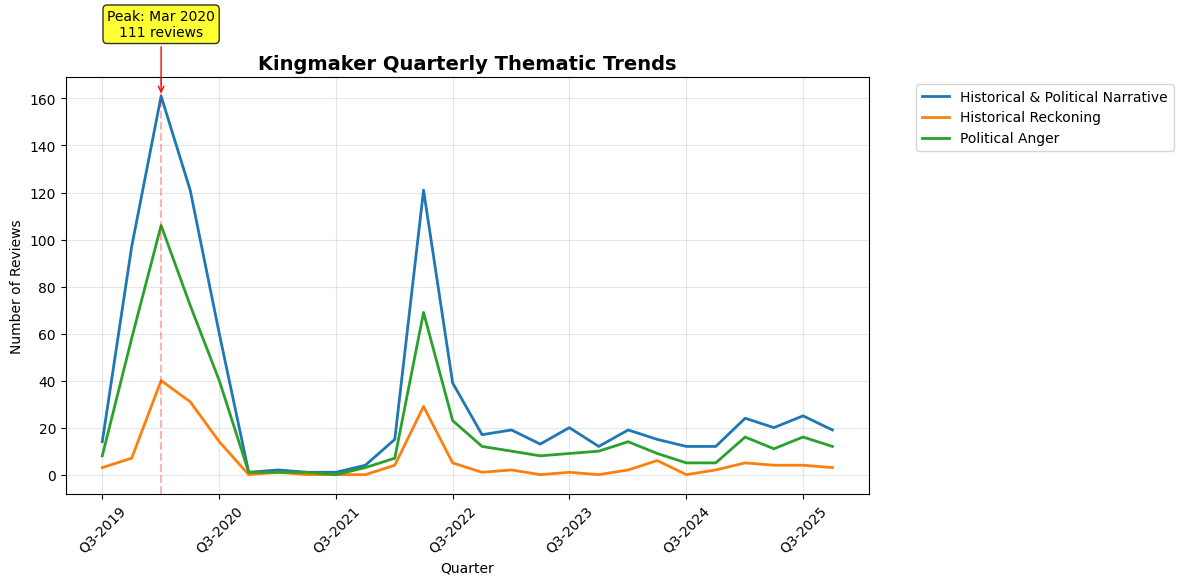

PEAK ANALYSIS SUMMARY
Peak Theme: Historical & Political Narrative
Peak Month: March 2020
Monthly Peak Value: 111 reviews
Quarter Containing Peak: Q1-2020


In [28]:
kingmaker_themes = {
    "Historical & Political Narrative": [
        "marcos", "imelda", "documentary", "people", "film", "truth", "real truth"
    ],
    "Political Anger": [
        "tangina", "marcos", "family tangina", "fuck marcoses", "rich"
    ],
    "Historical Reckoning": [
        "Truth", "perception", "neveragain", "neverforget", "forget"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/kingmaker_reviews.csv",
                     themes=kingmaker_themes,
                     title="Kingmaker Quarterly Thematic Trends")

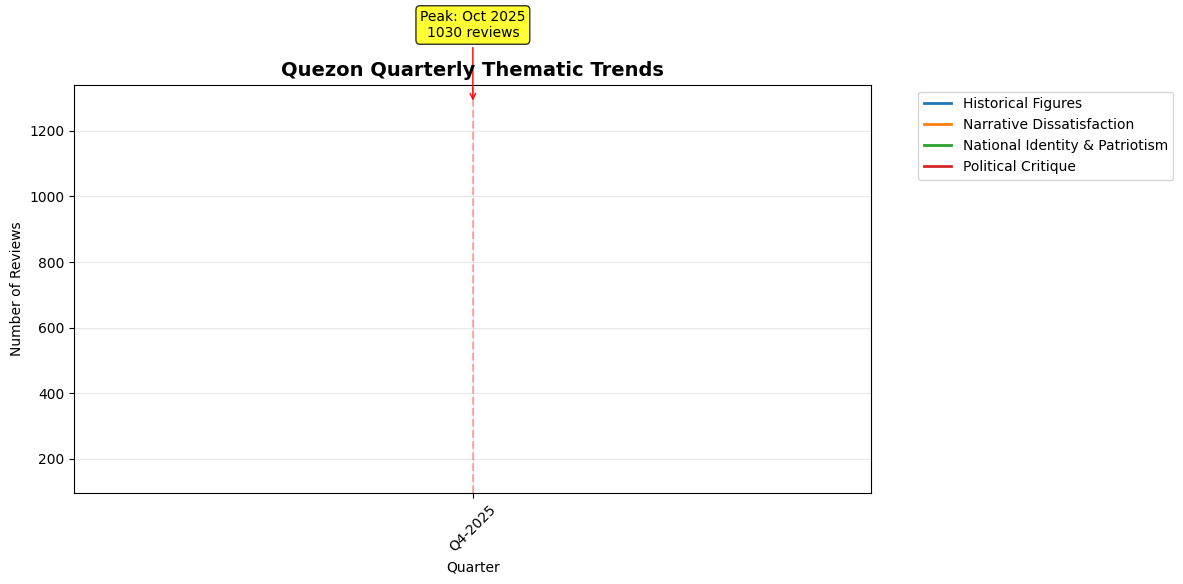

PEAK ANALYSIS SUMMARY
Peak Theme: National Identity & Patriotism
Peak Month: October 2025
Monthly Peak Value: 1030 reviews
Quarter Containing Peak: Q4-2025


In [33]:
quezon_themes = {
    "National Identity & Patriotism": [
        "quezon", "film", "philippines", "people", "bansa", "bayan", "ating"
    ],
    "Historical Figures": [
        "osmeña", "sergio", "enrile", "aguinaldo", "quezon"
    ],
    "Political Critique": [
        "trapo", "burat", "pastilan", "lamang"
    ],
    "Narrative Dissatisfaction": [
        "toxic", "doomed", "old yaoi", "yaoi"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/quezon_reviews.csv",
                     themes=quezon_themes,
                     title="Quezon Quarterly Thematic Trends")

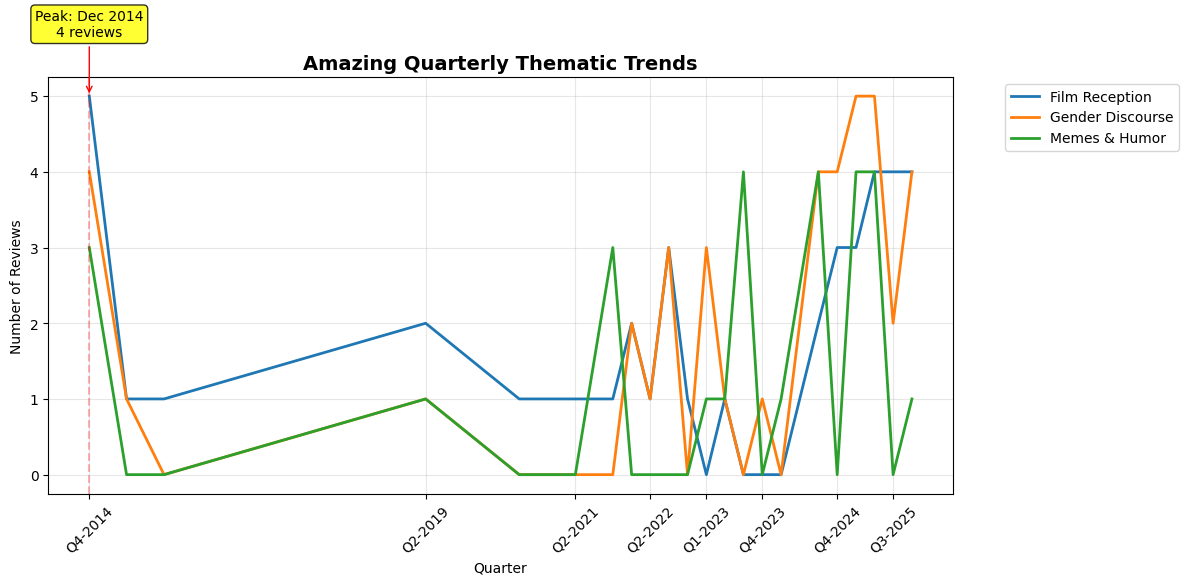

PEAK ANALYSIS SUMMARY
Peak Theme: Film Reception
Peak Month: December 2014
Monthly Peak Value: 4 reviews
Quarter Containing Peak: Q4-2014


In [30]:
amazing_themes = {
    "Film Reception": [
        "film", "vice", "ganda", "vice ganda"
    ],
    "Gender Discourse": [
        "bakla", "vice", "alex", "gay"
    ],
    "Memes & Humor": [
        "zombies", "plants vs zombies", "boom panes", "bimbee", "bomb", "boom"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/amazing_reviews.csv",
                     themes=amazing_themes,
                     title="Amazing Quarterly Thematic Trends")

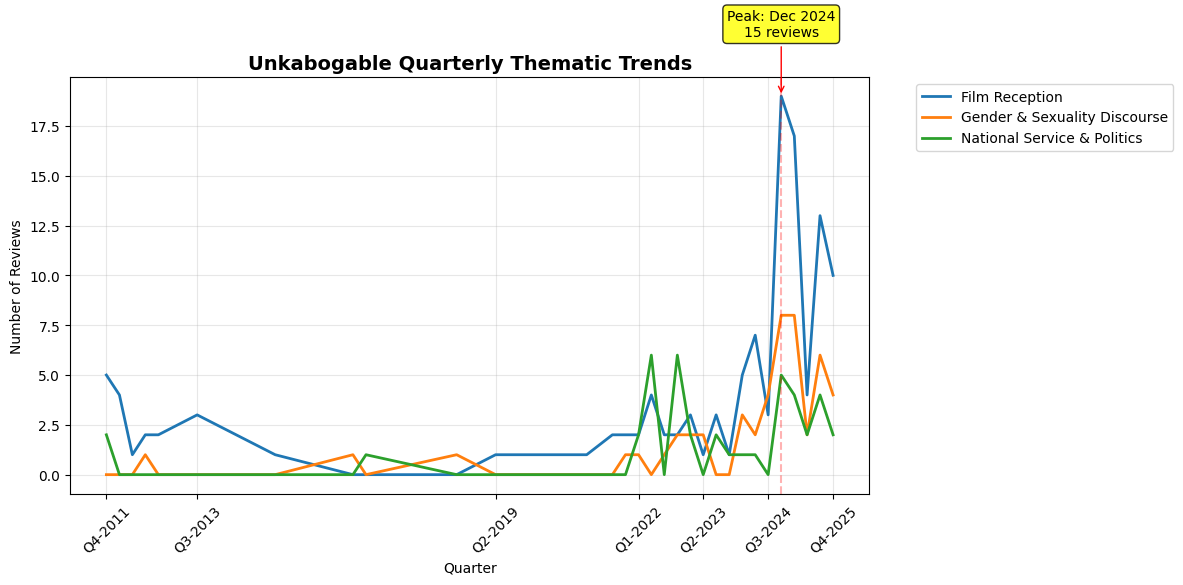

PEAK ANALYSIS SUMMARY
Peak Theme: Film Reception
Peak Month: December 2024
Monthly Peak Value: 15 reviews
Quarter Containing Peak: Q4-2024


In [31]:
unkabogable_themes = {
    "Gender & Sexuality Discourse": [
        "gay", "bakla", "homophobia", "homophobic", "pro", "mulan gay"
    ],
    "National Service & Politics": [
        "rotc", "mandatory", "military service", "service", "camp"
    ],
    "Film Reception": [
        "vice", "vice ganda", "comedy", "ganda", "film"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/unkabogable_reviews.csv",
                     themes=unkabogable_themes,
                     title="Unkabogable Quarterly Thematic Trends")

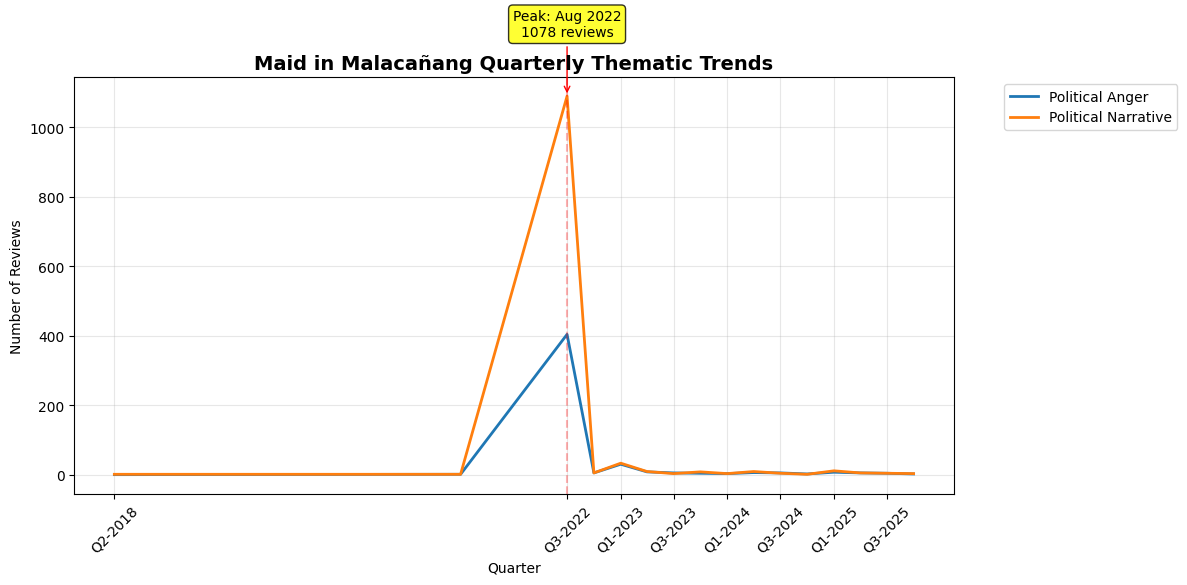

PEAK ANALYSIS SUMMARY
Peak Theme: Political Narrative
Peak Month: August 2022
Monthly Peak Value: 1078 reviews
Quarter Containing Peak: Q3-2022


In [32]:
maid_themes = {
    "Political Narrative": [
        "history", "marcos", "family", "malacañang", "film", "documentary", "legacy"
    ],
    "Political Anger": [
        "pangit", "basura", "tangina", "putangina", "marcos", "basura marcos"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/maid_reviews.csv",
                     themes=maid_themes,
                     title="Maid in Malacañang Quarterly Thematic Trends")